In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))

print("done")
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

done


In [2]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2

In [3]:


# 🔥 Step 1: Load Pretrained ResNet101 with Fine-Tuning
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the last 30% of layers for better fine-tuning
fine_tune_at = int(len(base_model.layers) * 0.7)  
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

# 🔥 Step 2: Define the New Fully Connected Layers
x = GlobalAveragePooling2D()(base_model.output)  # Adaptive pooling instead of Flatten
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)  
x = Dropout(0.4)(x)  # Prevent overfitting
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)  
x = Dense(1, activation='sigmoid')(x)  # Binary Classification Output

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [4]:
# Create the final model
resnet_model = Model(inputs=base_model.input, outputs=x)

# 🔥 Step 3: Optimized Learning Rate Scheduling
lr_schedule = ExponentialDecay(initial_learning_rate=1e-4, decay_steps=1000, decay_rate=0.96, staircase=True)

# 🔥 Step 4: Compile the Model with AdamW Optimizer
resnet_model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=1e-4),  
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [5]:
# 🔄 Step 5: Advanced Data Augmentation for Better Generalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],  # Handle different lighting conditions
    fill_mode='nearest',
    validation_split=0.2  
)

In [6]:
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/cat-and-dog/training_set/training_set',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    '/kaggle/input/cat-and-dog/training_set/training_set',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 6404 images belonging to 2 classes.
Found 1601 images belonging to 2 classes.


In [7]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/cat-and-dog/test_set/test_set/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 2023 images belonging to 2 classes.


In [8]:
# 🔄 Step 6: Train the Model with Optimized Parameters
resnet_history = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Increased epochs for fine-tuning
    verbose=1
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


201/201 ━━━━━━━━━━━━━━━━━━━━ 247s 920ms/step - accuracy: 0.5578 - loss: 1.9151 - val_accuracy: 0.5059 - val_loss: 1.9505
Epoch 2/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 125s 604ms/step - accuracy: 0.6014 - loss: 1.7568 - val_accuracy: 0.6177 - val_loss: 1.6546
Epoch 3/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 127s 615ms/step - accuracy: 0.6011 - loss: 1.6834 - val_accuracy: 0.5009 - val_loss: 2.7417
Epoch 4/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 128s 620ms/step - accuracy: 0.6314 - loss: 1.6006 - val_accuracy: 0.5091 - val_loss: 1.7281
Epoch 5/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 128s 618ms/step - accuracy: 0.6361 - loss: 1.5401 - val_accuracy: 0.6227 - val_loss: 1.5124
Epoch 6/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 124s 599ms/step - accuracy: 0.6312 - loss: 1.4893 - val_accuracy: 0.6527 - val_loss: 1.4292
Epoch 7/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 123s 594ms/step - accuracy: 0.6361 - loss: 1.4489 - val_accuracy: 0.5178 - val_loss: 1.5717
Epoch 8/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 124s 597ms/step - accuracy: 0.6528 - loss: 1.38

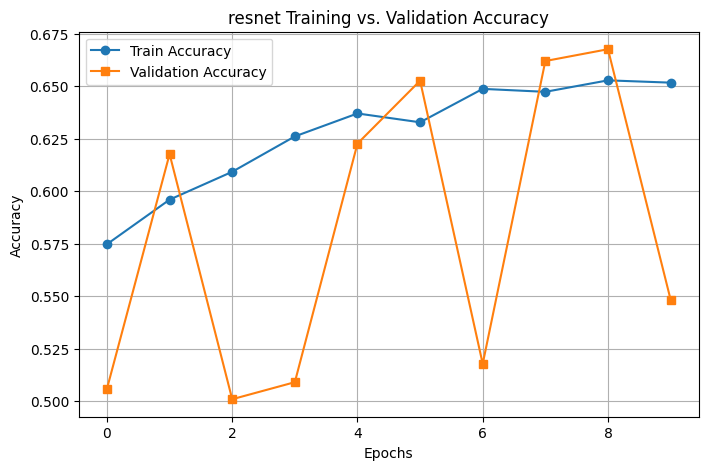

In [9]:
# 🔄 Step 7: Plot Training vs. Validation Accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(resnet_history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(resnet_history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('resnet Training vs. Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()



In [10]:
# 🔄 Step 8: Evaluate the Model on Test Data
test_loss, test_acc = resnet_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.8559 - loss: 1.0234
Test accuracy: 0.6016
